In [1]:
!pip install transformers
!pip install nlp_utils
!pip install rouge_score
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate
!pip install NLTK Downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 5.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c157b69839d39df69e69ddf5c9d92225bfbc3fb1594104a47810d614a406e78e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Looking in indexes: https://pypi.org/simple,

# New Section

# New Section

In [2]:
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import logging
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from transformers.keras_callbacks import KerasMetricCallback
from transformers import pipeline
from nlp_utils import *
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
import evaluate
from transformers import TFAutoModelForSeq2SeqLM
from transformers.keras_callbacks import KerasMetricCallback
from transformers import pipeline
import os
import tensorflow_datasets as tfds
from transformers.utils import send_example_telemetry
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
send_example_telemetry("summarization_notebook", framework="pytorch")

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:

#Importing Dataset
dataset_train=load_dataset("cnn_dailymail", '3.0.0', split='validation')
dataset_test=load_dataset("cnn_dailymail", '3.0.0', split='test')
print(dataset_train)

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 13368
})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     13368 non-null  object
 1   highlights  13368 non-null  object
 2   id          13368 non-null  object
dtypes: object(3)
memory usage: 313.4+ KB
                                             article  \
0  (CNN)Share, and your gift will be multiplied. ...   
1  (CNN)On the 6th of April 1996, San Jose Clash ...   
2  (CNN)French striker Bafetimbi Gomis, who has a...   
3  (CNN)It was an act of frustration perhaps more...   
4  (CNN)A Pennsylvania community is pulling toget...   

                                          highlights  \
0  Zully Broussard decided to give a kidney to a ...   
1  The 20th MLS season begins this weekend .\nLea...   
2  Bafetimbi Gomis collapses within 10 minutes of...   
3  Rory McIlroy throws club into water at WGC Cad...   
4  Cayman Naib, 13, hasn't been h

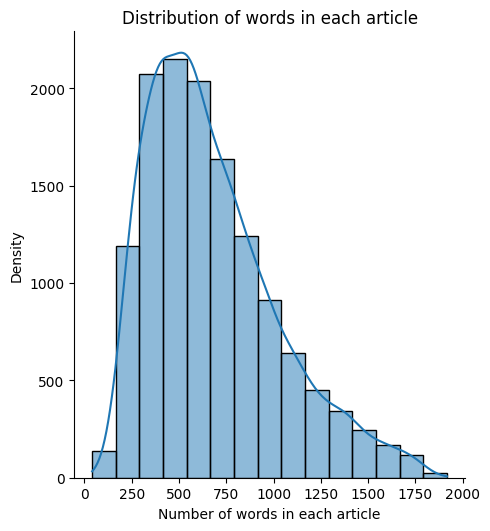

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('said', 50438), ('one', 21372), ('also', 16776), ('would', 16597), ('last', 15549), ('two', 14835), ('time', 13624), ('new', 13458), ('people', 13436), ('first', 13147)]


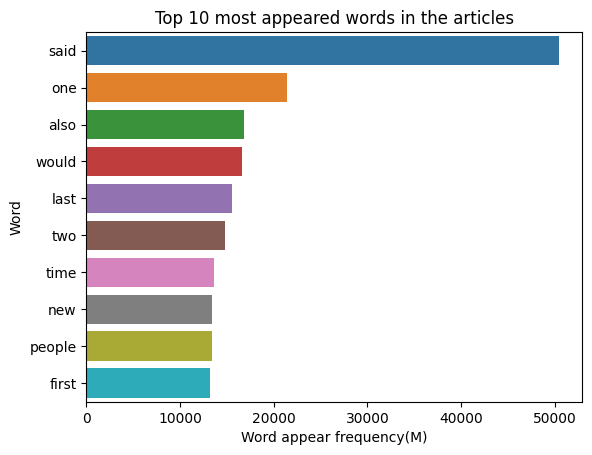

In [7]:
tf.debugging.set_log_device_placement(True)
#Exploratory Data Analysis for training dataset
df_train=pd.DataFrame(dataset_train)
df_train.info()
word_count=[]
print(df_train.head())


#EDA - Exploring word data
for i in df_train['article']:
    count=len(i.split())
    word_count.append(count)
def avg_list(list):
    return round(sum(list) / len(list))
print('Number of words of the longest article in training dataset:', max(word_count))
print('Number of words of the shortest article in training dataset:', min(word_count))
print('Average number of words of all articles in training dataset:', avg_list(word_count))
ax=sns.displot(word_count, kde=True, bins=15)
plt.xlabel('Number of words in each article')
plt.ylabel('Density')
plt.title('Distribution of words in each article')
plt.show()


#EDA - Word Frequency Analysis of training dataset article
def clean_text(text):
    text=text.lower()
    text=re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text=re.sub("([^\x00-\x7F])+", " ", text)
    return text

df_train['Article_cleaned']=df_train['article'].map(lambda x : clean_text(x))
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
corpus=[word for i in df_train['Article_cleaned'].str.split().values.tolist() for word in i if (word not in stop_words)]
most_common = FreqDist(corpus).most_common(10)
print(most_common)
words, frequency = [],[]
for word, count in most_common:
    words.append(word)
    frequency.append(count)
ax=sns.barplot(x=frequency, y=words)
plt.xlabel('Word appear frequency(M)')
plt.ylabel('Word')
plt.title('Top 10 most appeared words in the articles')
plt.show()


In [8]:
#Applying tokenization to dataset and applying model 't5-small'
model_checkpoint='t5-small'
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
prefix='summarize:'

def preprocess_function(examples):
    inputs=[prefix+ i for i in examples['article']]
    model_inputs=tokenizer(inputs, max_length=2000, truncation=True)
    labels=tokenizer(text_target=examples['highlights'], max_length=1000, truncation=True)
    model_inputs['labels']=labels['input_ids']
    return model_inputs

# dataset_train=df_train.to_dict('split')
tokenized_train=dataset_train.map(preprocess_function, batched=True)
tokenized_test=dataset_test.map(preprocess_function, batched=True)

data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_checkpoint)


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
batch_size = 5
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
  f"{model_name}-finetuned-CNNv2",
  evaluation_strategy = "epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=1,
  predict_with_generate=True,
  fp16=True,
  push_to_hub=True,
)

In [10]:
from datasets import load_metric

rouge = evaluate.load("rouge")
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

In [12]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
trainer = Seq2SeqTrainer(
  model,
  args,
  train_dataset=tokenized_train,
  eval_dataset=tokenized_test,
  data_collator=data_collator,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics
)

Cloning https://huggingface.co/Henry-Chan/t5-small-finetuned-CNNv2 into local empty directory.


In [13]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.888100,1.720389,0.244800,0.116800,0.202600,0.202700,18.998300


TrainOutput(global_step=2674, training_loss=1.918201786061232, metrics={'train_runtime': 1152.2468, 'train_samples_per_second': 11.602, 'train_steps_per_second': 2.321, 'total_flos': 5411706166345728.0, 'train_loss': 1.918201786061232, 'epoch': 1.0})

In [14]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/231M [00:00<?, ?B/s]

Upload file runs/May26_04-46-30_5cc395c98bf6/events.out.tfevents.1685076531.5cc395c98bf6.859.0:   0%|         …

To https://huggingface.co/Henry-Chan/t5-small-finetuned-CNNv2
   da73ab8..b496630  main -> main

   da73ab8..b496630  main -> main

To https://huggingface.co/Henry-Chan/t5-small-finetuned-CNNv2
   b496630..c10f946  main -> main

   b496630..c10f946  main -> main



'https://huggingface.co/Henry-Chan/t5-small-finetuned-CNNv2/commit/b4966309fc686052f15bf86c82cf361633bff421'

In [15]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

In [16]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Henry-Chan/t5-small-finetuned-CNNv2")
summarizer(text)

Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


[{'summary_text': "The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs . It's the most aggressive action on tackling the climate crisis in American history ."}]